<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/%5B20250408%5D%20FedAvg-DL%20with%20MLP-LSTM%20model%20on%20WSN-BFSF%20with%20early%20stopped.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**FedAvg-DL // with clean MLP-LSTM model 4 classes on WSN-BFSF**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout, Flatten
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.utils import to_categorical

In [ ]:
# Load dataset
dataset = pd.read_csv("dataset.csv") #WSN-BFSF 4 classes dataset

# Preprocessing: Handle missing values (if any)
dataset = dataset.dropna() # Remove missing values

In [ ]:
dataset

,Event,Time,S_Node,Node_id,Rest_Energy,Trace_Level,Mac_Type_Pckt,Source_IP_Port,Des_IP_Port,Packet_Size,TTL,Hop_Count,Broadcast_ID,Dest_Node_Num,Dest_Seq_Num,Src_Node_ID,Src_Seq_Num,Class
0,1,0.100000,79,79,600.000000,5,0,79.255,1.255,48,30,1,1,100,0,79,4,0
1,2,0.100963,78,78,599.979723,5,800,79.255,1.255,48,30,1,1,100,0,79,4,0
2,2,0.100963,76,76,599.979722,5,800,79.255,1.255,48,30,1,1,100,0,79,4,0
3,2,0.100964,75,75,599.979722,5,800,79.255,1.255,48,30,1,1,100,0,79,4,0
4,2,0.100964,118,118,599.979722,5,800,79.255,1.255,48,30,1,1,100,0,79,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312101,4,656.526536,140,140,465.332078,5,800,140.255,1.255,48,30,1,31,100,16,140,68,1
312102,4,657.209643,140,140,465.191806,5,800,140.255,1.255,48,30,1,33,100,16,140,72,1
312103,4,657.891729,140,140,465.051737,5,800,140.255,1.255,48,30,1,35,100,16,140,76,1
312104,4,658.574656,140,140,464.911501,5,800,140.255,1.255,48,30,1,37,100,16,140,80,1


**Data Preprocessing**

In [ ]:
# Encode non-numeric columns (if any)
for column in dataset.columns:
    if dataset[column].dtype == 'object':  # Identify categorical columns
        dataset[column] = LabelEncoder().fit_transform(dataset[column])

# Separate features (X) and target (y)
X = dataset.drop(['Class'], axis=1)  # Assuming 'Class' is the target column
y = dataset['Class']

In [ ]:
print("Original Class Distribution:", np.bincount(y))

Original Class Distribution: [262851  11766   7645  29844]


In [ ]:
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
!pip install -U imbalanced-learn

**Data Balancing utilized SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE
# Balance dataset using SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Verify the balanced dataset distribution
print("Balanced Class Distribution:", np.bincount(y))

Balanced Class Distribution: [262851 262851 262851 262851]


**Split data into 80% Training and 20% Testing**

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)

**The hybrid MLP + LSTM model**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten, TimeDistributed, InputLayer
from keras.regularizers import l2
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

# Convert target to categorical (one-hot encoding)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Reshape the input data for LSTM compatibility
# Assuming the input features need to be reshaped into a 3D array: (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define the hybrid MLP + LSTM model with regularization
def build_hybrid_model(input_shape, num_classes):
    model = Sequential()

    # Input Layer
    model.add(InputLayer(input_shape=input_shape))

    # LSTM Layer
    model.add(LSTM(64, activation='tanh', return_sequences=False, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))  # Dropout for regularization

    # MLP Layers
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))  # Dropout for regularization
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))  # Dropout for regularization

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Build and compile the model
input_shape = (X_train.shape[1], X_train.shape[2])  # Adjusted for LSTM input format
num_classes = y_train.shape[1]
model = build_hybrid_model(input_shape, num_classes)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with early stopping
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
26286/26286 ━━━━━━━━━━━━━━━━━━━━ 227s 9ms/step - accuracy: 0.7862 - loss: 0.6090 - val_accuracy: 0.9179 - val_loss: 0.2581
Epoch 2/50
26286/26286 ━━━━━━━━━━━━━━━━━━━━ 225s 9ms/step - accuracy: 0.9131 - loss: 0.2795 - val_accuracy: 0.9321 - val_loss: 0.2385
Epoch 3/50
26286/26286 ━━━━━━━━━━━━━━━━━━━━ 226s 9ms/step - accuracy: 0.9316 - loss: 0.2325 - val_accuracy: 0.9477 - val_loss: 0.1894
Epoch 4/50
26286/26286 ━━━━━━━━━━━━━━━━━━━━ 226s 9ms/step - accuracy: 0.9398 - loss: 0.2106 - val_accuracy: 0.9662 - val_loss: 0.1405
Epoch 5/50
26286/26286 ━━━━━━━━━━━━━━━━━━━━ 227s 9ms/step - accuracy: 0.9442 - loss: 0.2009 - val_accuracy: 0.9590 - val_loss: 0.1504
Epoch 6/50
26286/26286 ━━━━━━━━━━━━━━━━━━━━ 226s 9ms/step - accuracy: 0.9531 - loss: 0.1774 - val_accuracy: 0.9636 - val_loss: 0.1375
Epoch 7/50
26286/26286 ━━━━━━━━━━━━━━━━━━━━ 225s 9ms/step - accuracy: 0.9560 - loss: 0.1691 - val_accuracy: 0.9434 - val_loss: 0.1816
Epoch 8/50
26286/26286 ━━━━━━━━━━━━━━━━━━━━ 226s 9ms/step - ac

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
# Metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print("Accuracy: {:.10f}".format(accuracy))
print("Precision: {:.10f}".format(precision))
print("Recall: {:.10f}".format(recall))
print("F1-Score: {:.10f}".format(f1))

Accuracy: 0.9846871567
Precision: 0.9847859883
Recall: 0.9846871567
F1-Score: 0.9846886172


In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print("Accuracy: {:.10f}".format(accuracy))
print("Precision: {:.10f}".format(precision))
print("Recall: {:.10f}".format(recall))
print("F1-Score: {:.10f}".format(f1))

6572/6572 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
Accuracy: 0.9846871567
Precision: 0.9847859883
Recall: 0.9846871567
F1-Score: 0.9846886172


In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[51474   511   583     2]
 [  886 51624    17    43]
 [   71    18 52481     0]
 [    0   601   488 51482]]


In [ ]:
# Detection Rate (Recall for each class)
print("Detection Rates per Class:", recall_score(y_true_classes, y_pred_classes, average=None))

Detection Rates per Class: [0.97915161 0.98200495 0.99830702 0.97928516]


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
# Import roc_curve
from sklearn.metrics import roc_curve # This line imports the roc_curve function
from sklearn.metrics import auc # This line imports the auc function
import matplotlib.pyplot as plt # Import the pyplot module from matplotlib as plt

# After training, calculate ROC curves and AUC for each class
n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, n_classes))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.10f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")

# Save the plot as a high-resolution image
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.close()

# Calculate and print AUC scores for each class
print("\nAUC Scores for each class:")
for i in range(n_classes):
    print(f"Class {i}: {roc_auc[i]:.10f}")

# Calculate macro-average AUC
macro_roc_auc = np.mean(list(roc_auc.values()))
print(f"\nMacro-average AUC: {macro_roc_auc:.10f}")

<ipython-input-16-c5170017384f>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, n_classes))



AUC Scores for each class:
Class 0: 0.9995722805
Class 1: 0.9994638028
Class 2: 0.9997274291
Class 3: 0.9997695215

Macro-average AUC: 0.9996332585


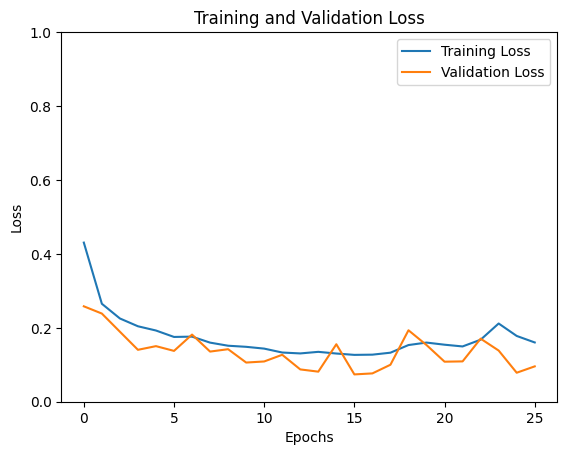

In [ ]:
# Plot Training and Validation Loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)  # Set y-axis scale to 1
plt.legend()
plt.show()

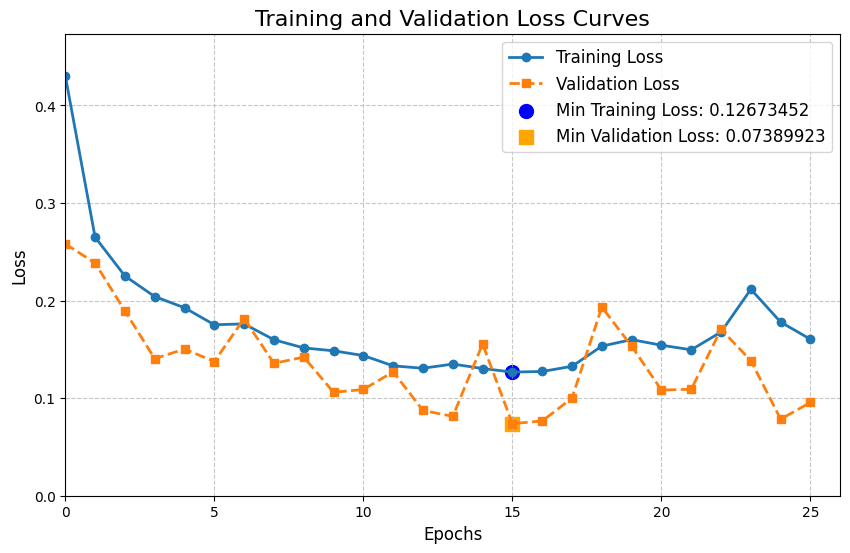

In [ ]:
# prompt: Plot Training and Validation Loss in the way more mathmatically

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ... (Your existing code) ...


# Plot Training and Validation Loss with mathematical details
plt.figure(figsize=(10, 6))  # Adjust figure size for better visualization
plt.plot(history.history['loss'], label='Training Loss', marker='o', linestyle='-', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s', linestyle='--', linewidth=2)

# Add mathematical details to the plot
min_training_loss = min(history.history['loss'])
min_val_loss = min(history.history['val_loss'])
min_training_loss_epoch = history.history['loss'].index(min_training_loss)
min_val_loss_epoch = history.history['val_loss'].index(min_val_loss)

plt.scatter(min_training_loss_epoch, min_training_loss, color='blue', marker='o', s=100, label=f'Min Training Loss: {min_training_loss:.8f}')
plt.scatter(min_val_loss_epoch, min_val_loss, color='orange', marker='s', s=100, label=f'Min Validation Loss: {min_val_loss:.8f}')


plt.title('Training and Validation Loss Curves', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)  # Add a grid for better readability
plt.legend(fontsize=12)

plt.xlim(0, len(history.history['loss'])) # Ensure x-axis covers all epochs
plt.ylim(0, max(max(history.history['loss']), max(history.history['val_loss']))*1.1) #adjust y axis limit

plt.show()


<ipython-input-20-9755d3f7a37e>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, n_classes))


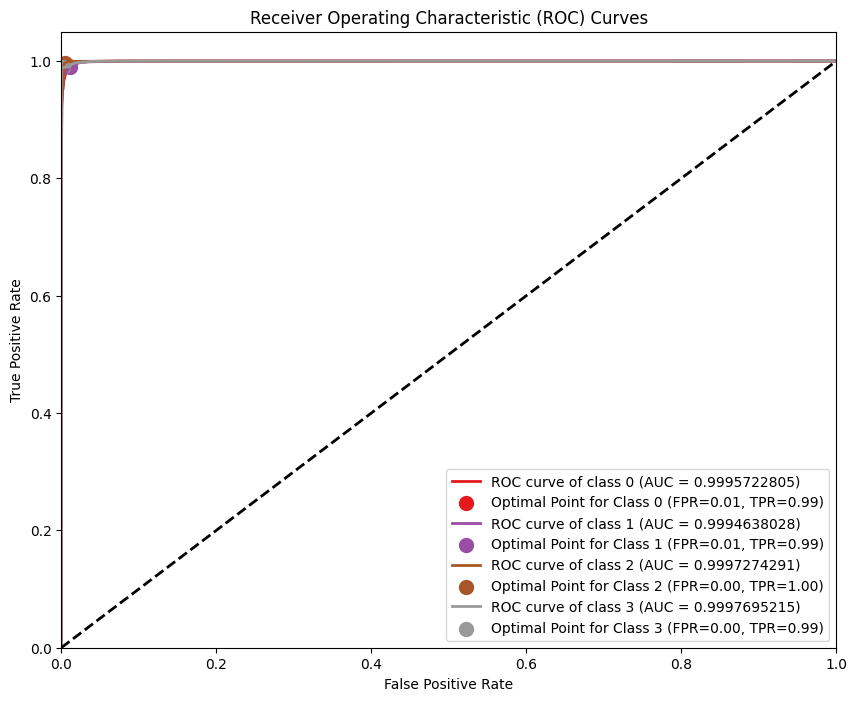


AUC Scores for each class:
Class 0: 0.9995722805
Class 1: 0.9994638028
Class 2: 0.9997274291
Class 3: 0.9997695215

Macro-average AUC: 0.9996332585


In [ ]:
# prompt: Plot ROC curves and AUC for each class in the way more mathamaticall and show label to point out an important value

from sklearn.metrics import roc_curve, auc

# ... (Your existing code) ...

# After training, calculate ROC curves and AUC for each class
n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, n_classes))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.10f})')
    # Find the point closest to (0,1)
    distances = np.sqrt(fpr[i]**2 + (1-tpr[i])**2)
    min_index = np.argmin(distances)
    plt.scatter(fpr[i][min_index], tpr[i][min_index], marker='o', s=100, color=color,
                label=f'Optimal Point for Class {i} (FPR={fpr[i][min_index]:.2f}, TPR={tpr[i][min_index]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")

# Save the plot as a high-resolution image
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show() # Display the plot


# Calculate and print AUC scores for each class
print("\nAUC Scores for each class:")
for i in range(n_classes):
    print(f"Class {i}: {roc_auc[i]:.10f}")

# Calculate macro-average AUC
macro_roc_auc = np.mean(list(roc_auc.values()))
print(f"\nMacro-average AUC: {macro_roc_auc:.10f}")


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def conf_mat(d1,d2):
  cm = confusion_matrix(d1, d2)
  #plt.figure(figsize=(6,5.5))
  plt.figure(figsize=(8,6.5))
  #ax = sns.heatmap(cm,  fmt='2', annot=True, cmap='tab20c')
  ax = sns.heatmap(cm, annot=True, fmt=".0f", cmap="PuBu",
                 vmin=0, vmax=35000, center=0, square=True, linewidths=1.5)
  sns.set(font_scale=1)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values\n');
  ax.xaxis.set_ticklabels(['Normal','Flooding','Blackhole','Forwarding'])
  ax.yaxis.set_ticklabels(['Normal','Flooding','Blackhole','Forwarding'])
  ##plt.xticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  ##plt.yticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.tight_layout()
  # plt.savefig("F1.eps", format = 'eps')
  plt.show()

Confusion Matrix of Hybrid RF-LSTM Model


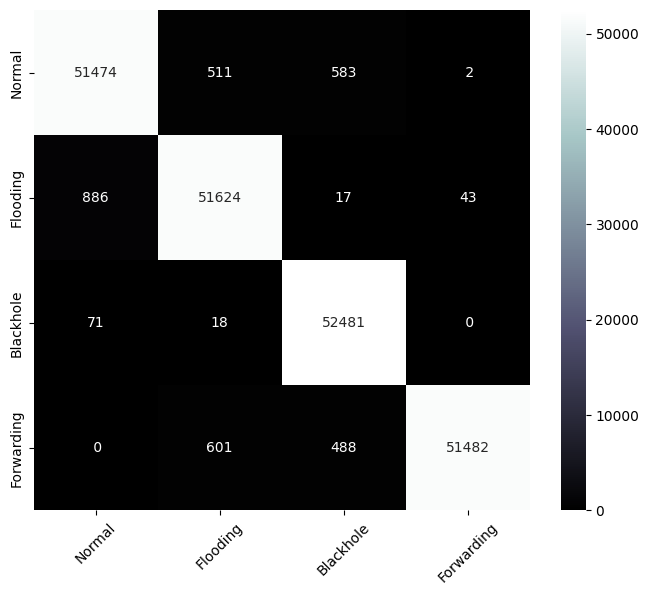

In [ ]:
print("Confusion Matrix of Hybrid RF-LSTM Model")
#conf_mat(np.argmax(y_test, axis=1), test_rf_lstm_predictions)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8,6.5))
# Use plt.xticks to set custom tick labels
# Using get_xticklabels() to access the current labels and then setting rotation.
plt.xticks(ticks=np.arange(4), labels=['Normal','Flooding','Blackhole','Forwarding'], rotation=45)
plt.yticks(ticks=np.arange(4), labels=['Normal','Flooding','Blackhole','Forwarding'], rotation=45)
sns.heatmap(conf_matrix, annot=True, fmt='2', cmap='bone',xticklabels=['Normal','Flooding','Blackhole','Forwarding'], yticklabels=['Normal','Flooding','Blackhole','Forwarding'])
sns.set(font_scale=1)
plt.show() # Display the heatmap

In [ ]:
def conf_mat(d1,d2):
  cm = confusion_matrix(y_true_classes, y_pred_classes)
  #plt.figure(figsize=(6,5.5))
  plt.figure(figsize=(8,6.5))
  #ax = sns.heatmap(cm,  fmt='2', annot=True, cmap='tab20c')
  ax = sns.heatmap(cm, annot=True, fmt=".0f", cmap="gist_yarg",
                 vmin=0, vmax=5600, center=0, square=True, linewidths=1.5)
  sns.set(font_scale=0.85)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values\n');
  ax.xaxis.set_ticklabels(['Normal','Flooding','Blackhole','Forwarding'])
  ax.yaxis.set_ticklabels(['Normal','Flooding','Blackhole','Forwarding'])
  plt.xticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.yticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.tight_layout()
  # plt.savefig("F1.eps", format = 'eps')
  plt.show()

Confusion Matrix of Federated DL// MLP-LSTM Model


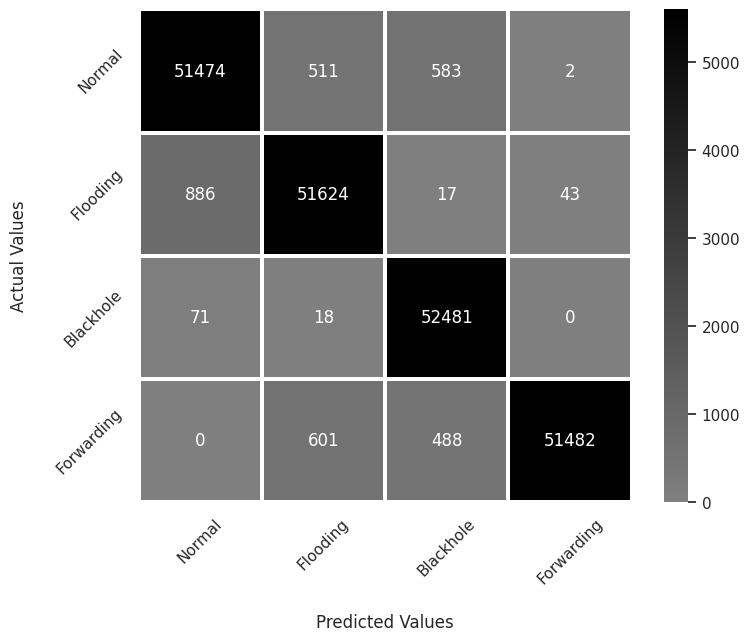

In [ ]:
print("Confusion Matrix of Federated DL// MLP-LSTM Model")
conf_mat(y_true_classes, y_pred_classes)

Confusion Matrix of MLP-LSTM Model


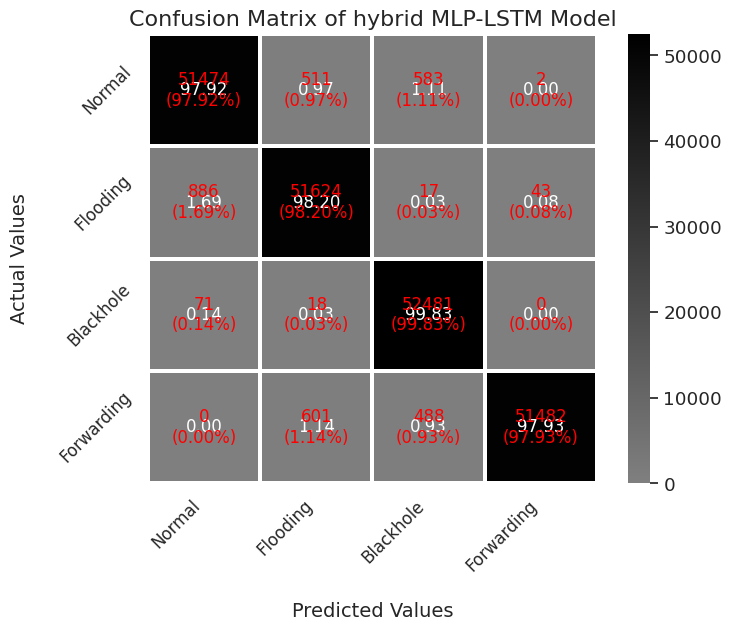

In [ ]:
# prompt: Plot the Confusion Matrix of Federated DL// MLP-LSTM Model in the way more mathmatically

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ... (Your existing code) ...

def conf_mat(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6.5))

    # Annotate with percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    ax = sns.heatmap(cm, annot=cm_percent, fmt=".2f", cmap="gist_yarg",  # Use a suitable colormap
                     vmin=0, vmax=52500, center=0, square=True, linewidths=1.5, annot_kws={"fontsize":12}) # Customize font size
    sns.set(font_scale=1.2) # Adjust font scale for better readability
    ax.set_xlabel('\nPredicted Values', fontsize=14)
    ax.set_ylabel('Actual Values\n', fontsize=14)
    ax.xaxis.set_ticklabels(['Normal','Flooding','Blackhole','Forwarding'], fontsize=12)
    ax.yaxis.set_ticklabels(['Normal','Flooding','Blackhole','Forwarding'], fontsize=12)
    plt.xticks(rotation=45, ha='right') # Align x-axis labels
    plt.yticks(rotation=45) # Ensure y-axis labels are horizontal
    plt.title('Confusion Matrix of hybrid MLP-LSTM Model', fontsize=16) # Add title


    # Add text annotations for actual counts within each cell
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j + 0.5, i + 0.5, f'{cm[i, j]}\n({cm_percent[i,j]:.2f}%)',
                     ha='center', va='center', color='red', fontsize=12)  # Customize fontsize for annotations



    plt.tight_layout()
    plt.show()

print("Confusion Matrix of MLP-LSTM Model")
conf_mat(y_true_classes, y_pred_classes)

**Federated Learning Simulation (FedAvg)**

In [ ]:
# Federated Learning Simulation (FedAvg)
def federated_learning_simulation(X_train, y_train, X_test, y_test, num_clients=5):
    # Split training data among clients
    client_data = np.array_split(X_train, num_clients)
    client_labels = np.array_split(y_train, num_clients)

    # Initialize the global model
    global_model = build_hybrid_model(input_shape, num_classes)
    global_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Compile the global model
    global_weights = global_model.get_weights()

    for round in range(10):  # Simulate 10 communication rounds
        local_weights = []

        for i in range(num_clients):
            local_model = build_hybrid_model(input_shape, num_classes)
            local_model.set_weights(global_weights)
            local_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Compile the local model

            # Train the local model
            local_model.fit(client_data[i], client_labels[i], epochs=1, batch_size=32, verbose=0)
            local_weights.append(local_model.get_weights())

        # Aggregate weights (FedAvg)
        global_weights = [
            np.mean([local_weights[j][i] for j in range(num_clients)], axis=0)
            for i in range(len(global_weights))
        ]
        global_model.set_weights(global_weights)

        # Evaluate the global model
        loss, acc = global_model.evaluate(X_test, y_test, verbose=0)
        print(f"Round {round + 1}: Global Model Accuracy = {acc:.10f}")

# Call the federated learning simulation function
federated_learning_simulation(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Round 1: Global Model Accuracy = 0.4765045643
Round 2: Global Model Accuracy = 0.9052860141
Round 3: Global Model Accuracy = 0.9059329629
Round 4: Global Model Accuracy = 0.9062270522
Round 5: Global Model Accuracy = 0.9064064026
Round 6: Global Model Accuracy = 0.9061446786
Round 7: Global Model Accuracy = 0.9065592885
Round 8: Global Model Accuracy = 0.9064357877
Round 9: Global Model Accuracy = 0.9056800604
Round 10: Global Model Accuracy = 0.9061417580


In [ ]:
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Function to measure model performance
def evaluate_global_model(global_model, X_test, y_test):
    y_pred = global_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Compute performance metrics
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    print("\nModel Performance Metrics:")
    print(f"Accuracy: {accuracy:.10f}")
    print(f"Precision: {precision:.10f}")
    print(f"Recall: {recall:.10f}")
    print(f"F1-Score: {f1:.10f}")
    print("\nConfusion Matrix:")
    print(cm)

    return accuracy, precision, recall, f1

# Function to analyze communication overhead
def analyze_communication_overhead(local_weights, global_weights):
    communication_cost = 0
    for i in range(len(local_weights)):
        # Compute the size of weights transmitted between clients and server
        communication_cost += sum(w.nbytes for w in local_weights[i])
    communication_cost += sum(w.nbytes for w in global_weights)

    print(f"\nCommunication Overhead: {communication_cost / (1024 ** 2):.2f} MB")  # in megabytes

# Federated Learning Simulation (FedAvg)
def federated_learning_simulation(X_train, y_train, X_test, y_test, num_clients=5):
    client_data = np.array_split(X_train, num_clients)
    client_labels = np.array_split(y_train, num_clients)

    global_model = build_hybrid_model(input_shape, num_classes)
    global_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    global_weights = global_model.get_weights()

    communication_overhead = []
    latency_per_round = []

    for round in range(10):  # Simulate 10 communication rounds
        local_weights = []

        start_time = time.time()  # Start measuring latency

        for i in range(num_clients):
            local_model = build_hybrid_model(input_shape, num_classes)
            local_model.set_weights(global_weights)
            local_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

            local_model.fit(client_data[i], client_labels[i], epochs=1, batch_size=32, verbose=0)
            local_weights.append(local_model.get_weights())

        # Aggregate weights (FedAvg)
        global_weights = [
            np.mean([local_weights[j][i] for j in range(num_clients)], axis=0)
            for i in range(len(global_weights))
        ]
        global_model.set_weights(global_weights)

        # Measure latency
        end_time = time.time()
        latency = end_time - start_time
        latency_per_round.append(latency)

        # Measure communication overhead
        analyze_communication_overhead(local_weights, global_weights)

        # Evaluate the global model
        loss, acc = global_model.evaluate(X_test, y_test, verbose=0)
        print(f"\nRound {round + 1}: Global Model Accuracy = {acc:.10f}")

        # Evaluate model performance metrics
        evaluate_global_model(global_model, X_test, y_test)

    # Summarize overall latency
    print("\nLatency Analysis:")
    print(f"Average Latency per Round: {np.mean(latency_per_round):.2f} seconds")
    print(f"Total Latency for 10 Rounds: {np.sum(latency_per_round):.2f} seconds")

# Call the federated learning simulation function
federated_learning_simulation(X_train, y_train, X_test, y_test)


Communication Overhead: 0.77 MB

Round 1: Global Model Accuracy = 0.6239523888
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step

Model Performance Metrics:
Accuracy: 0.6239524092
Precision: 0.5904822357
Recall: 0.6239524092
F1-Score: 0.5709786700

Confusion Matrix:
[[65771   318     4  1862    58]
 [ 5606 52456   166  9785     0]
 [ 4384 46129  1700 15800     0]
 [ 4506  2369  7777 53362     0]
 [13842  4623     0 10652 38896]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 2: Global Model Accuracy = 0.9043538570
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step

Model Performance Metrics:
Accuracy: 0.9043538607
Precision: 0.9257269118
Recall: 0.9043538607
F1-Score: 0.9011894672

Confusion Matrix:
[[67054   694     0   147   118]
 [    2 41078 26930     3     0]
 [    0     7 67975    31     0]
 [ 4296   226    43 63449     0]
 [   27     2     0     0 67984]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 3: Global Model Accuracy = 0.9062799811
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 48s 4ms/step

Model Performance Metrics:
Accuracy: 0.9062799574
Precision: 0.9288298456
Recall: 0.9062799574
F1-Score: 0.9030244699

Confusion Matrix:
[[67653   208     0    62    90]
 [   18 41034 26923    38     0]
 [    0     7 67919    87     0]
 [ 4327    67     8 63612     0]
 [   34     2     0     0 67977]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 4: Global Model Accuracy = 0.9060564637
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 49s 5ms/step

Model Performance Metrics:
Accuracy: 0.9060564714
Precision: 0.9288501494
Recall: 0.9060564714
F1-Score: 0.9027643962

Confusion Matrix:
[[67787   110     0    39    77]
 [   81 40991 26927    14     0]
 [    0     0 67955    58     0]
 [ 4449   119    12 63434     0]
 [   61     0     0     0 67952]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 5: Global Model Accuracy = 0.9067504406
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 50s 5ms/step

Model Performance Metrics:
Accuracy: 0.9067504543
Precision: 0.9296504902
Recall: 0.9067504543
F1-Score: 0.9034655940

Confusion Matrix:
[[67753   115     0    69    76]
 [   24 40999 26927    63     0]
 [    0     0 67970    43     0]
 [ 4307    21    30 63656     0]
 [   31     5     0     0 67977]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 6: Global Model Accuracy = 0.9061535001
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 50s 5ms/step

Model Performance Metrics:
Accuracy: 0.9061535114
Precision: 0.9289827799
Recall: 0.9061535114
F1-Score: 0.9028968591

Confusion Matrix:
[[67776   136     0    23    78]
 [   35 41041 26925    12     0]
 [   11    10 67944    48     0]
 [ 4546    62    11 63395     0]
 [   15     2     0     0 67996]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 7: Global Model Accuracy = 0.9068180919
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 49s 5ms/step

Model Performance Metrics:
Accuracy: 0.9068180883
Precision: 0.9296649366
Recall: 0.9068180883
F1-Score: 0.9035454776

Confusion Matrix:
[[67766   116     0    54    77]
 [   41 41012 26930    30     0]
 [    0     0 68006     7     0]
 [ 4302    75    36 63601     0]
 [   15     5     0     0 67993]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 8: Global Model Accuracy = 0.9066798687
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step

Model Performance Metrics:
Accuracy: 0.9066798798
Precision: 0.9295218134
Recall: 0.9066798798
F1-Score: 0.9034374148

Confusion Matrix:
[[67703   179     0    55    76]
 [   19 41032 26938    24     0]
 [    0     0 68013     0     0]
 [ 4326    34    53 63601     0]
 [   26     5     0     0 67982]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 9: Global Model Accuracy = 0.9061505795
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step

Model Performance Metrics:
Accuracy: 0.9061505708
Precision: 0.9291025815
Recall: 0.9061505708
F1-Score: 0.9028951947

Confusion Matrix:
[[67758   148     1    29    77]
 [   56 41030 26927     0     0]
 [   34     0 67972     7     0]
 [ 4552    31    24 63407     0]
 [   27     2     0     0 67984]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 10: Global Model Accuracy = 0.9068445563
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 48s 5ms/step

Model Performance Metrics:
Accuracy: 0.9068445537
Precision: 0.9296940524
Recall: 0.9068445537
F1-Score: 0.9036028836

Confusion Matrix:
[[67757   125     0    55    76]
 [   22 41045 26939     7     0]
 [    0     0 68008     5     0]
 [ 4310    56    30 63618     0]
 [   34    20     0     0 67959]]

Latency Analysis:
Average Latency per Round: 419.71 seconds
Total Latency for 10 Rounds: 4197.12 seconds
